# Exploring Fake News Classifier using Stop Words and N-Grams Methods

## Import libraries

In [25]:
# Basic libraries
import pandas as pd 
import numpy as np 

# Visualization libraries
import matplotlib.pyplot as plt 
from matplotlib import rcParams
import seaborn as sns
from textblob import TextBlob
from plotly import tools
import plotly.graph_objs as go
from plotly.offline import iplot
%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 5]
import cufflinks as cf
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

# NLTK libraries
import nltk
import re
import string
from nltk.corpus import stopwords
#from wordcloud import WordCloud,STOPWORDS
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
 
# Miscellanous libraries
from collections import Counter

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')



## Importing datasets

In [26]:
# Reading the fake and true datasets
fake_news = pd.read_csv('fake.csv')
true_news = pd.read_csv('true.csv')

# print shape of fake dataset with rows and columns and information 
print ("The shape of the  data is (row, column):"+ str(fake_news.shape))
print (fake_news.info())
print("\n --------------------------------------- \n")

# print shape of true dataset with rows and columns and information
print ("The shape of the  data is (row, column):"+ str(true_news.shape))
print (true_news.info())

The shape of the  data is (row, column):(23481, 4)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23481 entries, 0 to 23480
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    23481 non-null  object
 1   text     23481 non-null  object
 2   subject  23481 non-null  object
 3   date     23481 non-null  object
dtypes: object(4)
memory usage: 733.9+ KB
None

 --------------------------------------- 

The shape of the  data is (row, column):(21417, 4)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21417 entries, 0 to 21416
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    21417 non-null  object
 1   text     21417 non-null  object
 2   subject  21417 non-null  object
 3   date     21417 non-null  object
dtypes: object(4)
memory usage: 669.4+ KB
None


## Creating the target column

In [27]:
# Target variable for fake news
fake_news['output'] = 0

# Target variable for true news
true_news['output'] = 1

## Concatenating title and text of news

In [28]:
# Concatenating and dropping for fake news
fake_news['news']=fake_news['title']+fake_news['text']
fake_news=fake_news.drop(['title', 'text'], axis=1)

# Concatenating and dropping for true news
true_news['news']=true_news['title']+true_news['text']
true_news=true_news.drop(['title', 'text'], axis=1)

# Rearranging the columns
fake_news = fake_news[['subject', 'date', 'news','output']]
true_news = true_news[['subject', 'date', 'news','output']]

## Converting the date columns to datetime format

In [29]:
fake_news['date'].value_counts()

May 10, 2017         46
May 26, 2016         44
May 6, 2016          44
May 5, 2016          44
May 11, 2016         43
                     ..
December 9, 2017      1
December 4, 2017      1
November 19, 2017     1
November 20, 2017     1
Jul 19, 2015          1
Name: date, Length: 1681, dtype: int64

In [30]:
# Removing links and the headline from the date column
fake_news=fake_news[~fake_news.date.str.contains("http")]
fake_news=fake_news[~fake_news.date.str.contains("HOST")]

In [31]:
# Converting the date to datetime format
fake_news['date'] = pd.to_datetime(fake_news['date'])
true_news['date'] = pd.to_datetime(true_news['date'])

## Appending two datasets

In [32]:
frames = [fake_news, true_news]
news_dataset = pd.concat(frames)
news_dataset

,subject,date,news,output
0,News,2017-12-31,Donald Trump Sends Out Embarrassing New Year’...,0
1,News,2017-12-31,Drunk Bragging Trump Staffer Started Russian ...,0
2,News,2017-12-30,Sheriff David Clarke Becomes An Internet Joke...,0
3,News,2017-12-29,Trump Is So Obsessed He Even Has Obama’s Name...,0
4,News,2017-12-25,Pope Francis Just Called Out Donald Trump Dur...,0
...,...,...,...,...
21412,worldnews,2017-08-22,'Fully committed' NATO backs new U.S. approach...,1
21413,worldnews,2017-08-22,LexisNexis withdrew two products from Chinese ...,1
21414,worldnews,2017-08-22,Minsk cultural hub becomes haven from authorit...,1
21415,worldnews,2017-08-22,Vatican upbeat on possibility of Pope Francis ...,1


## Punctuation Cleaning

In [37]:
# Creating a copy 
clean_news = news_dataset.copy()
clean_news_fake = fake_news.copy()
clean_news_true = true_news.copy()

In [34]:
# Data cleaning for easy reading
def review_cleaning(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

In [38]:
# Show the data table after cleaning
clean_news['news']=clean_news['news'].apply(lambda x:review_cleaning(x))
clean_news.head()

,subject,date,news,output
0,News,2017-12-31,donald trump sends out embarrassing new year’...,0
1,News,2017-12-31,drunk bragging trump staffer started russian ...,0
2,News,2017-12-30,sheriff david clarke becomes an internet joke...,0
3,News,2017-12-29,trump is so obsessed he even has obama’s name...,0
4,News,2017-12-25,pope francis just called out donald trump dur...,0


In [39]:
# Show the data table after cleaning
clean_news_fake['news']=clean_news_fake['news'].apply(lambda x:review_cleaning(x))
clean_news_fake.head()

,subject,date,news,output
0,News,2017-12-31,donald trump sends out embarrassing new year’...,0
1,News,2017-12-31,drunk bragging trump staffer started russian ...,0
2,News,2017-12-30,sheriff david clarke becomes an internet joke...,0
3,News,2017-12-29,trump is so obsessed he even has obama’s name...,0
4,News,2017-12-25,pope francis just called out donald trump dur...,0


In [40]:
# Show the data table after cleaning
clean_news_true['news']=clean_news_true['news'].apply(lambda x:review_cleaning(x))
clean_news_true.head()

,subject,date,news,output
0,politicsNews,2017-12-31,as us budget fight looms republicans flip thei...,1
1,politicsNews,2017-12-29,us military to accept transgender recruits on ...,1
2,politicsNews,2017-12-31,senior us republican senator let mr mueller do...,1
3,politicsNews,2017-12-30,fbi russia probe helped by australian diplomat...,1
4,politicsNews,2017-12-29,trump wants postal service to charge much more...,1


## Stop words

In [52]:
# All
stop = stopwords.words('english')
clean_news['news'] = clean_news['news'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
clean_news.head()



,subject,date,news,output
0,News,2017-12-31,donald trump sends embarrassing new year’s eve...,0
1,News,2017-12-31,drunk bragging trump staffer started russian c...,0
2,News,2017-12-30,sheriff david clarke becomes internet joke thr...,0
3,News,2017-12-29,trump obsessed even obama’s name coded website...,0
4,News,2017-12-25,pope francis called donald trump christmas spe...,0


In [53]:
# Fake
stop = stopwords.words('english')
clean_news_fake['news'] = clean_news_fake['news'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
clean_news_fake.head()

,subject,date,news,output
0,News,2017-12-31,donald trump sends embarrassing new year’s eve...,0
1,News,2017-12-31,drunk bragging trump staffer started russian c...,0
2,News,2017-12-30,sheriff david clarke becomes internet joke thr...,0
3,News,2017-12-29,trump obsessed even obama’s name coded website...,0
4,News,2017-12-25,pope francis called donald trump christmas spe...,0


In [54]:
# True
stop = stopwords.words('english')
clean_news_true['news'] = clean_news_true['news'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
clean_news_true.head()

,subject,date,news,output
0,politicsNews,2017-12-31,us budget fight looms republicans flip fiscal ...,1
1,politicsNews,2017-12-29,us military accept transgender recruits monday...,1
2,politicsNews,2017-12-31,senior us republican senator let mr mueller jo...,1
3,politicsNews,2017-12-30,fbi russia probe helped australian diplomat ti...,1
4,politicsNews,2017-12-29,trump wants postal service charge much amazon ...,1


## Count of news subject

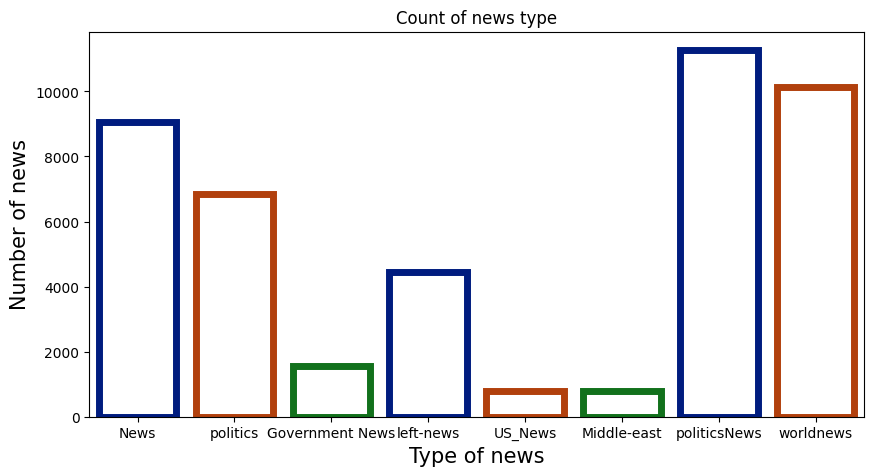

In [55]:
#Plotting the frequency plot
ax = sns.countplot(x="subject", data=clean_news,
                   facecolor=(0, 0, 0, 0),
                   linewidth=5,
                   edgecolor=sns.color_palette("dark", 3))

#Setting labels and font size
ax.set(xlabel='Type of news', ylabel='Number of news',title='Count of news type')
ax.xaxis.get_label().set_fontsize(15)
ax.yaxis.get_label().set_fontsize(15)

## Count of fake news and true news

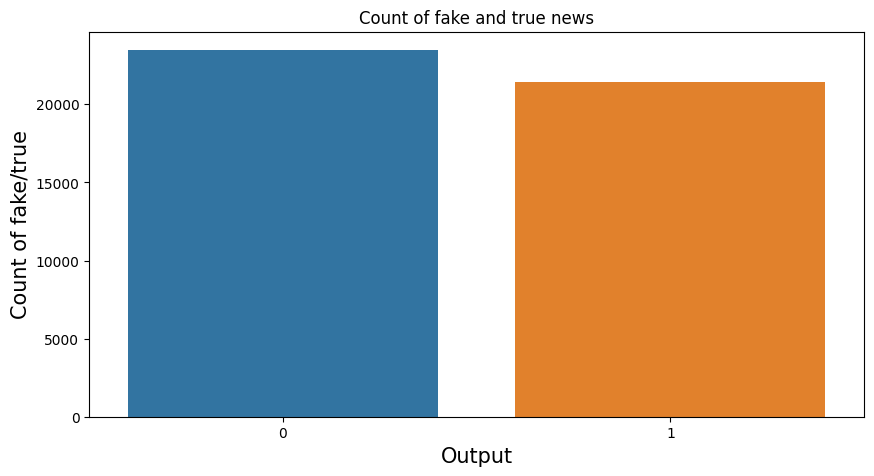

In [56]:
# Count of fake news and true news
ax=sns.countplot(x="output", data=clean_news)

# Setting labels and font size
ax.set(xlabel='Output', ylabel='Count of fake/true',title='Count of fake and true news')
ax.xaxis.get_label().set_fontsize(15)
ax.yaxis.get_label().set_fontsize(15)

## Unigram

In [57]:
# Combined news
# Function to get top n words
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

# Calling function and return only top 20 words
common_words = get_top_n_words(clean_news['news'], 20)

# Printing the word and frequency
for word, freq in common_words:
    print(word, freq)

# Creating the dataframe of word and frequency
df1 = pd.DataFrame(common_words, columns = ['news' , 'count'])

# Group by words and plot the sum
df1.groupby('news').sum()['count'].sort_values(ascending=False).iplot(
    kind='bar', yTitle='Count', linecolor='black', title='Top 20 words in news')

trump 140400
said 130258
us 68081
would 55422
president 53189
people 41718
one 36146
state 33190
new 31799
also 31209
obama 29881
clinton 29003
house 28716
government 27392
donald 27376
reuters 27348
states 26331
republican 25287
could 24356
white 23823


In [58]:
# Fake
# Function to get top n words
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

# Calling function and return only top 20 words
common_words = get_top_n_words(clean_news_fake['news'], 20)

# Printing the word and frequency
for word, freq in common_words:
    print(word, freq)

# Creating the dataframe of word and frequency
df1 = pd.DataFrame(common_words, columns = ['news' , 'count'])

# Group by words and plot the sum
df1.groupby('news').sum()['count'].sort_values(ascending=False).iplot(
    kind='bar', yTitle='Count', linecolor='black', title='Top 20 words in news')

trump 81627
said 31201
people 26370
president 26362
would 23667
one 23342
us 22966
obama 20124
clinton 18980
like 17937
donald 16865
hillary 15527
also 15245
new 14977
news 14927
even 13821
white 13570
time 12939
state 12875
media 11623


In [59]:
# True
# Function to get top n words
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

# Calling function and return only top 20 words
common_words = get_top_n_words(clean_news_true['news'], 20)

# Printing the word and frequency
for word, freq in common_words:
    print(word, freq)

# Creating the dataframe of word and frequency
df1 = pd.DataFrame(common_words, columns = ['news' , 'count'])

# Group by words and plot the sum
df1.groupby('news').sum()['count'].sort_values(ascending=False).iplot(
    kind='bar', yTitle='Count', linecolor='black', title='Top 20 words in news')

said 99057
trump 58773
us 45115
would 31755
reuters 26989
president 26827
state 20315
government 18654
house 17689
new 16822
states 16772
republican 15971
also 15964
united 15423
people 15348
told 14284
could 13938
one 12804
party 12756
last 12685


## Bigram

In [60]:
# All
# Function to get top bigram words
def get_top_n_bigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

# Calling function and return only top 20 words
common_words = get_top_n_bigram(clean_news['news'], 20)

# Printing the word and frequency
for word, freq in common_words:
    print(word, freq)
    
# Creating the dataframe of word and frequency
df3 = pd.DataFrame(common_words, columns = ['news' , 'count'])

# Group by words and plot the sum
df3.groupby('news').sum()['count'].sort_values(ascending=False).iplot(
    kind='bar', yTitle='Count', linecolor='black', title='Top 20 bigrams in news')

donald trump 25059
united states 18394
white house 15485
hillary clinton 9502
new york 8110
north korea 7053
president donald 6928
image via 6188
barack obama 5603
trump said 4816
prime minister 4753
president trump 4646
supreme court 4595
last year 4560
last week 4512
said statement 4425
fox news 4074
president obama 4065
islamic state 4014
national security 3858


In [61]:
# Fake
# Function to get top bigram words
def get_top_n_bigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

# Calling function and return only top 20 words
common_words = get_top_n_bigram(clean_news_fake['news'], 20)

# Printing the word and frequency
for word, freq in common_words:
    print(word, freq)
    
# Creating the dataframe of word and frequency
df3 = pd.DataFrame(common_words, columns = ['news' , 'count'])

# Group by words and plot the sum
df3.groupby('news').sum()['count'].sort_values(ascending=False).iplot(
    kind='bar', yTitle='Count', linecolor='black', title='Top 20 bigrams in news')

donald trump 14855
hillary clinton 6972
white house 6579
image via 6188
united states 6188
new york 4256
president trump 4006
president obama 3883
fox news 3406
barack obama 2270
fake news 1961
century wire 1928
supreme court 1913
trump campaign 1786
trump realdonaldtrump 1694
national security 1687
social media 1685
obama administration 1651
law enforcement 1575
bernie sanders 1561


In [62]:
# True
# Function to get top bigram words
def get_top_n_bigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

# Calling function and return only top 20 words
common_words = get_top_n_bigram(clean_news_true['news'], 20)

# Printing the word and frequency
for word, freq in common_words:
    print(word, freq)
    
# Creating the dataframe of word and frequency
df3 = pd.DataFrame(common_words, columns = ['news' , 'count'])

# Group by words and plot the sum
df3.groupby('news').sum()['count'].sort_values(ascending=False).iplot(
    kind='bar', yTitle='Count', linecolor='black', title='Top 20 bigrams in news')

united states 12206
donald trump 10204
white house 8906
north korea 6164
president donald 5930
prime minister 4168
said statement 3925
new york 3854
islamic state 3580
told reuters 3491
us president 3486
trump said 3460
reuters us 3347
last year 3336
barack obama 3333
last week 3311
told reporters 3176
said would 2973
president barack 2903
supreme court 2682


## Trigram

In [63]:
# All
# Function to get top trigram words
def get_top_n_trigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(3, 3), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

# Calling function and return only top 20 words
common_words = get_top_n_trigram(clean_news['news'], 20)
 
# Printing word and their respective frequencies
for word, freq in common_words:
    print(word, freq)

# Creating a dataframe with words and count
df6 = pd.DataFrame(common_words, columns = ['news' , 'count'])

# Grouping the words and plotting their frequencies
df6.groupby('news').sum()['count'].sort_values(ascending=False).iplot(
    kind='bar', yTitle='Count', linecolor='black', title='Top 20 trigrams in news')

president donald trump 6808
president barack obama 3735
new york times 2034
donald trump realdonaldtrump 1790
reuters president donald 1476
black lives matter 1436
president united states 1096
white house said 1050
presidentelect donald trump 1043
new york city 1006
president vladimir putin 955
news century wire 951
national security adviser 898
affordable care act 868
director james comey 860
speaker paul ryan 851
fbi director james 778
state rex tillerson 775
secretary state rex 765
russian president vladimir 745


In [64]:
# Fake
# Function to get top trigram words
def get_top_n_trigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(3, 3), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

# Calling function and return only top 20 words
common_words = get_top_n_trigram(clean_news_fake['news'], 20)
 
# Printing word and their respective frequencies
for word, freq in common_words:
    print(word, freq)

# Creating a dataframe with words and count
df6 = pd.DataFrame(common_words, columns = ['news' , 'count'])

# Grouping the words and plotting their frequencies
df6.groupby('news').sum()['count'].sort_values(ascending=False).iplot(
    kind='bar', yTitle='Count', linecolor='black', title='Top 20 trigrams in news')

donald trump realdonaldtrump 1692
new york times 1509
black lives matter 1381
news century wire 951
president donald trump 941
president united states 909
president barack obama 839
century wire says 727
video screen capture 724
image video screen 695
new york city 603
director james comey 503
fbi director james 484
image screen capture 441
make america great 427
affordable care act 394
donald trump jr 377
white house press 354
wall street journal 332
chip somodevillagetty images 322


In [65]:
# True
# Function to get top trigram words
def get_top_n_trigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(3, 3), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

# Calling function and return only top 20 words
common_words = get_top_n_trigram(clean_news_true['news'], 20)
 
# Printing word and their respective frequencies
for word, freq in common_words:
    print(word, freq)

# Creating a dataframe with words and count
df6 = pd.DataFrame(common_words, columns = ['news' , 'count'])

# Grouping the words and plotting their frequencies
df6.groupby('news').sum()['count'].sort_values(ascending=False).iplot(
    kind='bar', yTitle='Count', linecolor='black', title='Top 20 trigrams in news')

president donald trump 5867
president barack obama 2896
reuters president donald 1474
white house said 967
presidentelect donald trump 832
president vladimir putin 789
state rex tillerson 673
secretary state rex 672
national security adviser 629
russian president vladimir 611
speaker paul ryan 610
prime minister theresa 584
donald trump said 570
chancellor angela merkel 570
leader mitch mcconnell 568
democratic president barack 546
new york times 525
south china sea 523
respond request comment 515
told news conference 494


## Time series analysis- Fake/True news

In [66]:
#Creating the count of output based on date
fake=fake_news.groupby(['date'])['output'].count()
fake=pd.DataFrame(fake)

true=true_news.groupby(['date'])['output'].count()
true=pd.DataFrame(true)

#Plotting the time series graph
fig = go.Figure()
fig.add_trace(go.Scatter(
         x=true.index,
         y=true['output'],
         name='True',
    line=dict(color='blue'),
    opacity=0.8))

fig.add_trace(go.Scatter(
         x=fake.index,
         y=fake['output'],
         name='Fake',
    line=dict(color='red'),
    opacity=0.8))

fig.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=1, label="1m", step="month", stepmode="backward"),
            dict(count=6, label="6m", step="month", stepmode="backward"),
            dict(count=1, label="YTD", step="year", stepmode="todate"),
            dict(count=1, label="1y", step="year", stepmode="backward"),
            dict(step="all")
        ])
    )
)
        
    
fig.update_layout(title_text='True and Fake News',plot_bgcolor='rgb(248, 248, 255)',yaxis_title='Value')

fig.show()